# The Economic Costs of Conflict
### Abadie & Gardeazabel

This notebook reproduces the weights from the 2003 paper "The Economic Costs of Conflict: A Case Study of the Basque Country" by Alberto Abadie and Javier Gardeazabal. The study data is contained in the file `../data/basque.csv` (more detailed information on this dataset is available on page 2 of the ``R`` ``synth`` package documentation [here](https://cran.r-project.org/web/packages/Synth/Synth.pdf)).

In [1]:
import pandas as pd
from pysyncon import Dataprep, Synth
from pysyncon.utils import PlaceboTest

Firstly we prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

Next, we supply the `Dataprep` object to a `Synth` object. The optimisation scheme we use is [Nelder-Mead](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html) and the starting point for the optimisation is `equal` i.e. with all coordinates equal. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`). Note that the weights obtained by the synthetic control method is often highly sensitive to the chosen optimisation scheme and starting point.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [2]:
df = pd.read_csv("../data/basque.csv")

dataprep = Dataprep(
    foo=df,
    predictors=[
        "school.illit",
        "school.prim",
        "school.med",
        "school.high",
        "school.post.high",
        "invest",
    ],
    predictors_op="mean",
    time_predictors_prior=range(1964, 1970),
    special_predictors=[
        ("gdpcap", range(1960, 1970), "mean"),
        ("sec.agriculture", range(1961, 1970, 2), "mean"),
        ("sec.energy", range(1961, 1970, 2), "mean"),
        ("sec.industry", range(1961, 1970, 2), "mean"),
        ("sec.construction", range(1961, 1970, 2), "mean"),
        ("sec.services.venta", range(1961, 1970, 2), "mean"),
        ("sec.services.nonventa", range(1961, 1970, 2), "mean"),
        ("popdens", [1969], "mean"),
    ],
    dependent="gdpcap",
    unit_variable="regionname",
    time_variable="year",
    treatment_identifier="Basque Country (Pais Vasco)",
    controls_identifier=[
        "Spain (Espana)",
        "Andalucia",
        "Aragon",
        "Principado De Asturias",
        "Baleares (Islas)",
        "Canarias",
        "Cantabria",
        "Castilla Y Leon",
        "Castilla-La Mancha",
        "Cataluna",
        "Comunidad Valenciana",
        "Extremadura",
        "Galicia",
        "Madrid (Comunidad De)",
        "Murcia (Region de)",
        "Navarra (Comunidad Foral De)",
        "Rioja (La)",
    ],
    time_optimize_ssr=range(1960, 1970),
)

synth = Synth()
synth.fit(dataprep=dataprep, optim_method="Nelder-Mead", optim_initial="equal")

In [3]:
synth.weights()

Spain (Espana)                  0.000
Andalucia                       0.000
Aragon                          0.000
Principado De Asturias          0.000
Baleares (Islas)                0.000
Canarias                        0.000
Cantabria                       0.000
Castilla Y Leon                 0.000
Castilla-La Mancha              0.000
Cataluna                        0.851
Comunidad Valenciana            0.000
Extremadura                     0.000
Galicia                         0.000
Madrid (Comunidad De)           0.149
Murcia (Region de)              0.000
Navarra (Comunidad Foral De)    0.000
Rioja (La)                      0.000
Name: weights, dtype: float64

The synthetic control obtained from the optimisation is: $$\text{Synthetic Control} = 0.851 \times \text{Cataluna} + 0.149 \times \text{Madrid}.$$

The `path_plot` method shows the path of the treated unit and the synthetic control over time.

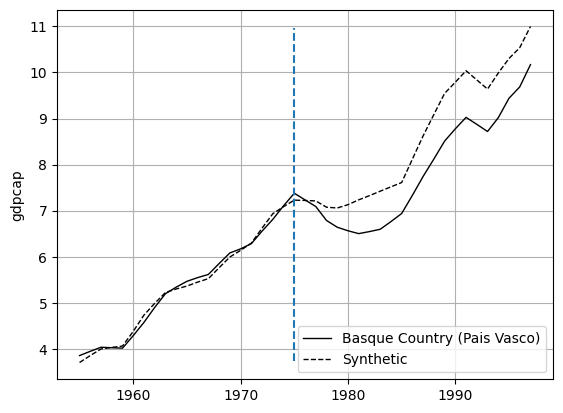

In [4]:
synth.path_plot(time_period=range(1955, 1998), treatment_time=1975)

The `gaps_plot` method shows the gaps (the difference between the treated unit and the synthetic control) over time.

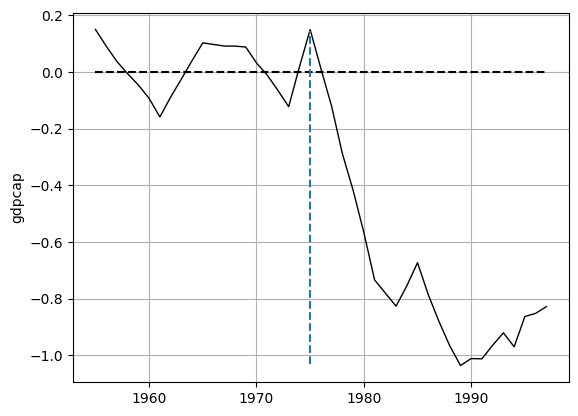

In [5]:
synth.gaps_plot(time_period=range(1955, 1998), treatment_time=1975)

Compute the average treatment effect on the treated unit (ATT) over the post-treatment time period. This method returns a standard error also.

In [6]:
synth.att(time_period=range(1975, 1998))

{'att': -0.6995654654228687, 'se': 0.07078075875424619}

The summary function give more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [7]:
synth.summary()

,V,treated,synthetic,sample mean
school.illit,0.073,39.888,256.336,323.826
school.prim,0.120,1031.742,2730.103,2182.453
school.med,0.003,90.359,223.340,148.864
school.high,0.102,25.728,63.437,47.133
school.post.high,0.011,13.480,36.154,26.163
invest,0.000,24.647,21.583,21.445
special.1.gdpcap,0.117,5.285,5.271,3.584
special.2.sec.agriculture,0.063,6.844,6.179,21.058
special.3.sec.energy,0.155,4.106,2.760,5.252
special.4.sec.industry,0.096,45.082,37.636,22.670


We can run a Placebo test using the `PlaceboTest` class. After instantiating it, we supply the original `Dataprep` object to it as well as a synthetic control method object (our `synth` from previously) and any options that we want to supply to the synthetic control method object (the optimisation scheme and starting point for the optimisation scheme).

In [8]:
placebo_test = PlaceboTest()
placebo_test.fit(
    dataprep=dataprep,
    scm=synth,
    scm_options={"optim_method": "Nelder-Mead", "optim_initial": "equal"},
)

(1/17) Completed placebo test for Spain (Espana).
(2/17) Completed placebo test for Castilla-La Mancha.
(3/17) Completed placebo test for Cantabria.
(4/17) Completed placebo test for Aragon.
(5/17) Completed placebo test for Baleares (Islas).
(6/17) Completed placebo test for Canarias.
(7/17) Completed placebo test for Principado De Asturias.
(8/17) Completed placebo test for Cataluna.
(9/17) Completed placebo test for Madrid (Comunidad De).
(10/17) Completed placebo test for Andalucia.
(11/17) Completed placebo test for Castilla Y Leon.
(12/17) Completed placebo test for Comunidad Valenciana.
(13/17) Completed placebo test for Extremadura.
(14/17) Completed placebo test for Rioja (La).
(15/17) Completed placebo test for Galicia.
(16/17) Completed placebo test for Murcia (Region de).
(17/17) Completed placebo test for Navarra (Comunidad Foral De).
Calculating treated unit gaps.
Done.


We can plot the gaps for the treated unit as well as all the placebos in one graph using the `gaps_plot` method of the `PlaceboTest` class.

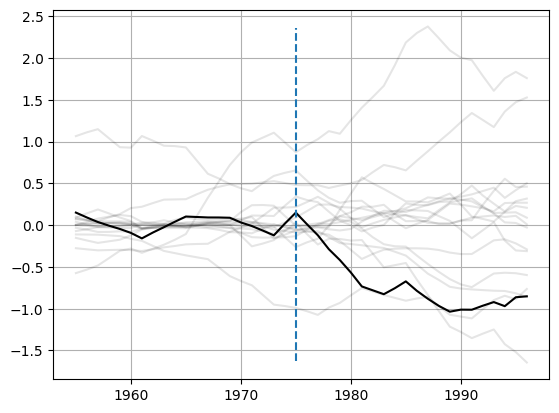

In [9]:
placebo_test.gaps_plot(
    time_period=range(1955, 1998), treatment_time=1975, exclude_units=["Spain (Espana)"]
)

We can refine the gaps plot by removing those placebos that did not have a good pre-treatment match, namely we can remove from the plot any placebo whose pre-treatment mean-square prediction error is $\le n\, \times $ the pre-treatment mean-square prediction error of the treated unit. The following graph does this for $n=1$.

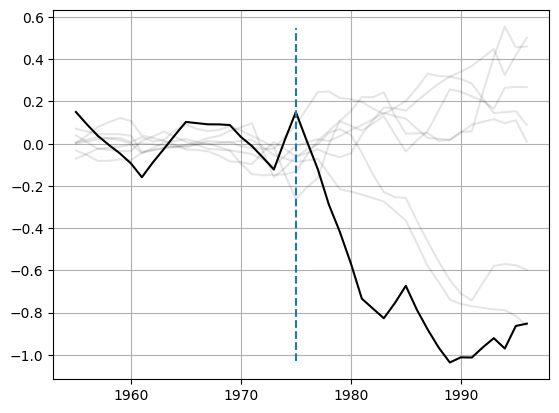

In [10]:
placebo_test.gaps_plot(
    time_period=range(1955, 1998),
    treatment_time=1975,
    exclude_units=["Spain (Espana)"],
    mspe_threshold=1,
)

We calculate $p$-value of Abadie et al's version of Fisher's exact hypothesis test for no effect of treatment null using the `pvalue` method.

In [11]:
placebo_test.pvalue(treatment_time=1975)

0.16666666666666666